In [2]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
import pandas as pd

from featureBuilder import featureBuilder

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


In [1]:
import torch 
model = torch.load("models/model_t_combined_trimmed_filtered_3class.pickle")

## Build dataframes and variables needed

In [3]:
# Load datas and concat into one dataframe 
# Load dataset 1
foldername='P001'
filename='part_P001_block_S004'
#filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
#filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df1 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

# Load dataset 2
foldername='P001'
filename='part_P001_block_S005'
df2 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

df = pd.concat([df1, df2], ignore_index=True)

In [4]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]

num_to_keep = min(len(focused_df), len(unfocused_df))

focused_df = focused_df.drop(focused_df.sample(len(focused_df) - num_to_keep).index)
unfocused_df = unfocused_df.drop(unfocused_df.sample(len(unfocused_df) - num_to_keep).index)

print("focused len:", len(focused_df), "unfocused len:", len(unfocused_df))


focused len: 420 unfocused len: 420


In [5]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)
for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
# for row_index,row in med_df.iterrows():
#     dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)

feature_df = pd.DataFrame(dictionary)
len(feature_df)

840

In [6]:
# Needed for visualizing LDA components
colors=['blue', 'orange', 'green']
class_names=["unfocused", "mid_focused", "focused"]

## LDA using sklearn 1 dim (2 possible outputs)
https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [7]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using random forest classifier
    classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + Random Forest accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.6547619047619048
Accuracy 0.7321428571428571
Accuracy 0.6845238095238095
Accuracy 0.6369047619047619
Accuracy 0.6488095238095238
Accuracy 0.6369047619047619
Accuracy 0.6428571428571429
Accuracy 0.625
Accuracy 0.7023809523809523
Accuracy 0.6488095238095238
Avg LDA + Random Forest accuracy: 0.6613095238095237


## LDA w/ SVM Classifier
https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [8]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using SVM
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + SVM accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.6428571428571429
Accuracy 0.7023809523809523
Accuracy 0.6785714285714286
Accuracy 0.6547619047619048
Accuracy 0.6547619047619048
Accuracy 0.6130952380952381
Accuracy 0.6488095238095238
Accuracy 0.6071428571428571
Accuracy 0.7321428571428571
Accuracy 0.6190476190476191
Avg LDA + SVM accuracy: 0.6553571428571429


In [9]:
zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
sorted_zip_list

[(-105.31801068131631, 'average norm_mean_first_difference'),
 (-61.562905540978235, 'right norm_mean_second_difference'),
 (-43.0219075725154, 'left norm_mean_second_difference'),
 (-15.88800525186798, 'left std_voltage'),
 (-14.499482820332535, 'right std_voltage'),
 (-9.642850611865999, 'left_minus_right mean_second_difference'),
 (-9.194611541857569, 'left mean_second_difference'),
 (-7.655101986878625, 'beta average'),
 (-6.459399420311664, 'average mean_second_difference'),
 (-4.445081686787261, 'alpha average_power'),
 (-4.281657380010008, 'alpha left'),
 (-3.6163625729181206, 'alpha right'),
 (-2.266209211900748, 'right mean_second_difference'),
 (-2.2131109379150136, 'delta average'),
 (-2.152359798036299, 'beta left_minus_right'),
 (-1.7945167603092536, 'theta left'),
 (-1.6378760883933294, 'theta average_power'),
 (-1.5493752970840868, 'alpha left_minus_right_power'),
 (-1.0498121293209908, 'left_minus_right norm_mean_second_difference'),
 (-1.0481574768808049, 'theta right'

LDA explained variance: [1.]


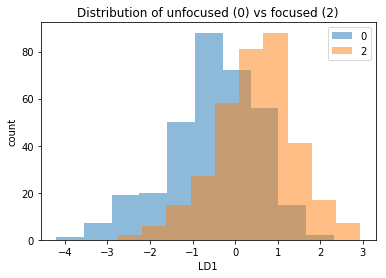

In [10]:
# Visualize LDA model 
print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(X_train, columns=['LDA 1'])
lda_feature_df['focused']=y_train.values

# Plot groups wrt LDA 1 dimension

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.hist(df['LDA 1'].values, alpha=0.5, label=class_name)

plt.xlabel('LD1')
plt.ylabel("count")
plt.title("Distribution of unfocused (0) vs focused (2)")    
plt.legend()
plt.show()

## LDA manual

In [ ]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [ ]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [ ]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [ ]:
within_class_scatter_matrix.shape

In [ ]:
between_class_scatter_matrix.shape

In [ ]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [ ]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
print("top 10 eigenvalues")
for pair in pairs[:10]:
    print(pair[0])

In [ ]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [ ]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

In [ ]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

In [ ]:
plt.xlabel('LD1')
plt.scatter(
    X_lda[:,0],
    y,
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)